In [225]:
import pandas as pd
import numpy as np
import networkx as nx
import nxviz as nz
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import xlwings as xw

In [226]:
data =  pd.read_excel('network_macro.xlsm')

In [227]:
data

,seviye,malzeme,miktar,baslangic tarihi,gelis tarihi,sure,next_assy,total_time,self_time,critical_path,calc_start_date,calc_finish_date
0,1,A,1,2022-12-10,2022-12-15,10,-,610,10,yes,2024-05-03,2024-05-13
1,2,B,2,2022-11-15,2022-12-10,25,A,610,35,NaN,2024-04-08,2024-05-03
2,3,C,2,2022-10-20,2022-11-15,200,B,610,235,NaN,2023-09-21,2024-04-08
3,4,X,1,2022-09-10,2022-10-20,350,C,610,585,NaN,2022-10-06,2023-09-21
4,4,Y,2,2022-09-10,2022-10-05,120,C,610,355,NaN,2023-05-24,2023-09-21
5,3,D,1,2022-09-10,2022-10-30,280,B,610,315,NaN,2023-07-03,2024-04-08
6,3,E,1,2022-10-01,2022-10-15,350,B,610,385,NaN,2023-04-24,2024-04-08
7,2,F,3,2022-09-15,2022-10-02,60,A,610,610,yes,2022-09-11,2024-05-03


In [228]:
def find_upper_assy(x):
   
    assy=data.loc[(data['seviye']<x[0]) & (data.index<x.name),'malzeme'].tail(1).to_string(index=False)
    if assy.isalpha():
        return assy
    else:
        return '-'

In [229]:
data['next_assy'] = data.apply(find_upper_assy,axis=1)
data

,seviye,malzeme,miktar,baslangic tarihi,gelis tarihi,sure,next_assy,total_time,self_time,critical_path,calc_start_date,calc_finish_date
0,1,A,1,2022-12-10,2022-12-15,10,-,610,10,yes,2024-05-03,2024-05-13
1,2,B,2,2022-11-15,2022-12-10,25,A,610,35,NaN,2024-04-08,2024-05-03
2,3,C,2,2022-10-20,2022-11-15,200,B,610,235,NaN,2023-09-21,2024-04-08
3,4,X,1,2022-09-10,2022-10-20,350,C,610,585,NaN,2022-10-06,2023-09-21
4,4,Y,2,2022-09-10,2022-10-05,120,C,610,355,NaN,2023-05-24,2023-09-21
5,3,D,1,2022-09-10,2022-10-30,280,B,610,315,NaN,2023-07-03,2024-04-08
6,3,E,1,2022-10-01,2022-10-15,350,B,610,385,NaN,2023-04-24,2024-04-08
7,2,F,3,2022-09-15,2022-10-02,60,A,610,610,yes,2022-09-11,2024-05-03


In [230]:
T = nx.DiGraph()  #create a directional graph
activities = data["next_assy"].unique().tolist()

T.add_nodes_from(activities)   #adding nodes

T.nodes() #view the nodes

NodeView(('-', 'A', 'B', 'C'))

In [231]:



activities_edges = [(a,b) for a,b in data[["malzeme","next_assy"]].to_numpy()]

T.add_edges_from(activities_edges)   #add edges


T.edges()

OutEdgeView([('A', '-'), ('B', 'A'), ('C', 'B'), ('X', 'C'), ('Y', 'C'), ('D', 'B'), ('E', 'B'), ('F', 'A')])

In [232]:
#add weights to the existing edges
activities_weights = data["sure"].to_list()
i=0
for s,d in T.edges():
    T[s][d]['weight'] =activities_weights[i]
    i+=1

T.edges(data=True)

OutEdgeDataView([('A', '-', {'weight': 10}), ('B', 'A', {'weight': 25}), ('C', 'B', {'weight': 200}), ('X', 'C', {'weight': 350}), ('Y', 'C', {'weight': 120}), ('D', 'B', {'weight': 280}), ('E', 'B', {'weight': 350}), ('F', 'A', {'weight': 60})])

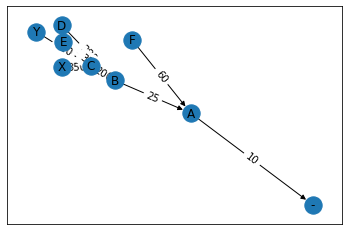

In [233]:
#Graph the network
pos= nx.spring_layout(T)
nx.draw_networkx_nodes(T,pos)
nx.draw_networkx_edges(T,pos,arrows=True)
nx.draw_networkx_edge_labels(T,pos,edge_labels=nx.get_edge_attributes(T,'weight'))
nx.draw_networkx_labels(T,pos)
plt.savefig('network.png',dpi=100)
plt.show()

In [234]:
print(nx.shortest_path(T,'X','-',weight='weight'))
nx.shortest_path_length(T,'X','-',weight='weight')

['X', 'C', 'B', 'A', '-']


585

In [235]:
print(nx.dag_longest_path(T,weight='weight'))
nx.dag_longest_path_length(T,weight='weight')

['X', 'C', 'B', 'A', '-']


585

In [236]:
def find_short(x):
    return nx.shortest_path_length(T,x[1],'-',weight='weight')

In [237]:
data["total_time"] = nx.dag_longest_path_length(T,weight='weight')
data["self_time"] = data.apply(find_short,axis=1)
data

,seviye,malzeme,miktar,baslangic tarihi,gelis tarihi,sure,next_assy,total_time,self_time,critical_path,calc_start_date,calc_finish_date
0,1,A,1,2022-12-10,2022-12-15,10,-,585,10,yes,2024-05-03,2024-05-13
1,2,B,2,2022-11-15,2022-12-10,25,A,585,35,NaN,2024-04-08,2024-05-03
2,3,C,2,2022-10-20,2022-11-15,200,B,585,235,NaN,2023-09-21,2024-04-08
3,4,X,1,2022-09-10,2022-10-20,350,C,585,585,NaN,2022-10-06,2023-09-21
4,4,Y,2,2022-09-10,2022-10-05,120,C,585,355,NaN,2023-05-24,2023-09-21
5,3,D,1,2022-09-10,2022-10-30,280,B,585,315,NaN,2023-07-03,2024-04-08
6,3,E,1,2022-10-01,2022-10-15,350,B,585,385,NaN,2023-04-24,2024-04-08
7,2,F,3,2022-09-15,2022-10-02,60,A,585,70,yes,2022-09-11,2024-05-03


In [238]:
today = dt.datetime.today().strftime("%Y-%m-%d")
critic_index = data[data["self_time"]==data['self_time'].max()].index.tolist()[0]
critic_list = nx.shortest_path(T,data.iloc[critic_index][1],'-',weight='weight')
data["critical_path"]=''
data.loc[(data.index <= critic_index) & data['malzeme'].isin(critic_list),'critical_path']='yes'
#data = data.drop(['self_time'],axis=1)
earliest_begin= max(data['baslangic tarihi'].min().strftime("%Y-%m-%d"),today)
earliest_begin = dt.datetime.strptime(earliest_begin,"%Y-%m-%d")
calc_finish=  earliest_begin + timedelta(nx.dag_longest_path_length(T,weight='weight'))
calc_finish

datetime.datetime(2024, 4, 18, 0, 0)

In [239]:
def calc_start_date(x):
    return calc_finish- timedelta(x[8])

def calc_finish_date(x):
    return x[10] + timedelta(x[5])

In [240]:
data['calc_start_date'] = data.apply(calc_start_date,axis=1)
data['calc_finish_date'] = data.apply(calc_finish_date,axis=1)

In [241]:
data

,seviye,malzeme,miktar,baslangic tarihi,gelis tarihi,sure,next_assy,total_time,self_time,critical_path,calc_start_date,calc_finish_date
0,1,A,1,2022-12-10,2022-12-15,10,-,585,10,yes,2024-04-08,2024-04-18
1,2,B,2,2022-11-15,2022-12-10,25,A,585,35,yes,2024-03-14,2024-04-08
2,3,C,2,2022-10-20,2022-11-15,200,B,585,235,yes,2023-08-27,2024-03-14
3,4,X,1,2022-09-10,2022-10-20,350,C,585,585,yes,2022-09-11,2023-08-27
4,4,Y,2,2022-09-10,2022-10-05,120,C,585,355,,2023-04-29,2023-08-27
5,3,D,1,2022-09-10,2022-10-30,280,B,585,315,,2023-06-08,2024-03-14
6,3,E,1,2022-10-01,2022-10-15,350,B,585,385,,2023-03-30,2024-03-14
7,2,F,3,2022-09-15,2022-10-02,60,A,585,70,,2024-02-08,2024-04-08


In [242]:
data[data['critical_path']=='yes'].index.to_list()

[0, 1, 2, 3]

In [255]:
wb = xw.Book("network_macro.xlsm")
ws = wb.sheets["Sheet1"]

ws['A1'].options(pd.DataFrame,header=1,index=False,expand='table').value = data

ws.autofit(axis="columns")

yes_list = data[data['critical_path']=='yes'].index.to_list()  #filter the critical path value 'yes' and find its indexes

rownum= xw.Range('B1').current_region.last_cell.row  #find the lastest row of the B column

xw.Range(f'B1:B{rownum}').color = None #remove the color of B column

for cell in yes_list:
    xw.Range(f"B{int(cell)+2}").color = '#D10000'

ws.used_range.api.AutoFilter(Field:=1)

wb.save('network_macro.xlsm')

In [244]:
import plotly.express as px

colors= ['#D10000', '#45B08C']
fig = px.timeline(data, x_start="calc_start_date", x_end="calc_finish_date", y="malzeme",color='critical_path',color_discrete_sequence=colors)
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_layout()
fig.write_html("gant.html")
fig.show()
